In [1]:
import numpy as np
try:  
    import cupy as xp  
    USE_GPU = True 
except ImportError:  
    import numpy as xp 
    print('No Cupy')
    USE_GPU = False 

import matplotlib.pyplot as plt
from tqdm import tqdm

# to mute the warnings of lal 
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

from Triangle.Constants import *
from Triangle.FFTTools import *
from Triangle.Noise import *
from Triangle.Orbit import *
from Triangle.Data import * 
from Triangle.GW import * 
from Triangle.TDI import * 

from gbgpu.gbgpu import GBGPU
from gbgpu.utils.constants import *
from gbgpu.utils.utility import *

# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

# np.random.seed(114514)

No Cupy


PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/Users/taijidatacenter/.local/lib/python3.9/site-packages/gbgpu-0.1-py3.9-macosx-11.0-arm64.egg/gbgpu/gbgpu.py:25: UserWarning: tdi module not found. No sensitivity information will be included.
  warnings.warn("tdi module not found. No sensitivity information will be included.")
/Users/taijidatacenter/.local/lib/python3.9/site-packages/gbgpu-0.1-py3.9-macosx-11.0-arm64.egg/gbgpu/utils/utility.py:15: UserWarning: tdi module not found. No sensitivity information will be included.
  warnings.warn("tdi module not found. No sensitivity information will be included.")


## Initialize time-domain waveform simulation 

In [2]:
Tobs = YEAR 
dt = 10. 
tcb_times = np.arange(int(Tobs / dt)) * dt
Tobs = len(tcb_times) * dt   

# orbit model 
ORBIT_DIR = '/Users/taijidatacenter/workspace/Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB'
orbit = Orbit(OrbitDir=ORBIT_DIR)

# generator for the unprojected waveforms
gb_waveform_generator = GB_Injection(use_gpu=False)

# take TDI-A2 channels as an example 
A2_string, _, _ = TDIStringManipulation.AETStringsfromXString(GeneralTDIResponse.X2_strings)

# initialize TDI response 
gb_response_generator = GeneralTDIResponse(
    orbit=orbit, 
    Pstring=A2_string, 
    tcb_times=tcb_times, 
    use_gpu=False, 
    drop_points=int(1000/dt), # drop 1000s at the beginning and end to avoid the invalid data caused by TDI calculation 
    linear_interp=True, # should be enough for GBs 
    )

## Initialize frequency-domain waveform 

In [3]:
Npoints = 512

gb = GBGPU(
    use_gpu=False, 
    orbit_file=ORBIT_DIR,
    unequal_arm=True,
    )

## Load population for test 

In [4]:
GB_catalogue = np.load("/Users/taijidatacenter/workspace/Triangle-GB/Examples/BrightGBParams.npy")
GB_parameters = dict(
    A=GB_catalogue[:, 0], 
    f0=GB_catalogue[:, 1], 
    fdot0=GB_catalogue[:, 2], 
    inclination=GB_catalogue[:, 5], 
    phase0=GB_catalogue[:, 4], 
    longitude=GB_catalogue[:, 6], 
    latitude=GB_catalogue[:, 7], 
    psi=GB_catalogue[:, 8], 
)

## Compare single source 

In [5]:
# generate time-domain waveform 
test_GB_idx = 1
test_params = dict()
for k, v in GB_parameters.items(): 
    test_params[k] = v[test_GB_idx]

test_td_waveform = gb_response_generator(parameters=test_params, waveform_generator=gb_waveform_generator)

test_params

{'A': 2.2664276241669803e-23,
 'f0': 0.005126896573508148,
 'fdot0': 3.1119635064213916e-16,
 'inclination': 2.6310305711230266,
 'phase0': 2.731163602319862,
 'longitude': 4.610408789386678,
 'latitude': -0.164524335584303,
 'psi': 1.144394243305052}

In [6]:
# Fourier transform and select the frequency band of signal 
ff, xff = FFT_window(test_td_waveform, 1./dt) 
test_fd_waveform_from_td = np.concatenate(([0.], xff)) # add a DC term to match the convension of xp.fft.rfft
test_frequency = np.concatenate(([0.], ff))

fmin = test_params["f0"] - 1e-5
fmax = test_params["f0"] + 1e-5 
cutinds = np.where((test_frequency<=fmax)&(test_frequency>=fmin))[0]
test_fd_waveform_from_td = test_fd_waveform_from_td[cutinds]
test_frequency = test_frequency[cutinds]

test_frequency.shape, test_fd_waveform_from_td.shape 

((631,), (631,))

In [7]:
# generate frequency-domain waveform 
amp_in = np.atleast_1d(test_params["A"])
f0_in = np.atleast_1d(test_params["f0"])
fdot_in = np.atleast_1d(test_params["fdot0"])
fddot_in = 11.0 / 3.0 * fdot_in ** 2 / f0_in
phi0_in = np.atleast_1d(test_params["phase0"])
iota_in = np.atleast_1d(test_params["inclination"])
psi_in = np.atleast_1d(test_params["psi"])
lam_in = np.atleast_1d(test_params["longitude"])
beta_sky_in = np.atleast_1d(test_params["latitude"])
params = np.array(
    [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
)
gb.run_wave(*params, N=Npoints, dt=dt, T=Tobs, oversample=4, tdi2=True)

# fill into a template that matches the shape of above time-domain calculation 
test_fd_waveform = np.zeros((1, 2, len(cutinds)), dtype=np.complex128)
gb.fill_global_template(group_index=np.array([0,]), templates=test_fd_waveform, A=gb.A, E=gb.E, start_inds=gb.start_inds, start_freq_ind=cutinds[0], N=Npoints)
test_fd_waveform = test_fd_waveform[0][0]

(0.0051248965735081475, 0.005128896573508148)

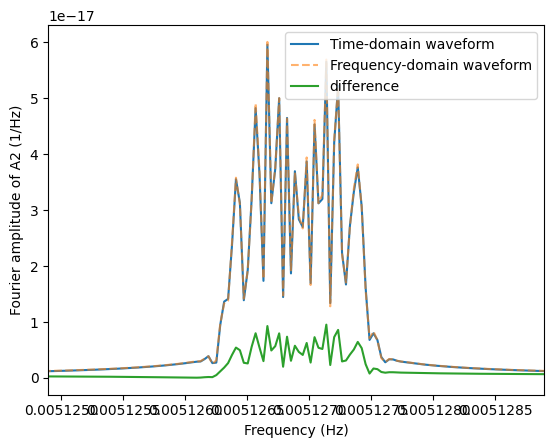

In [8]:
plt.plot(test_frequency, np.abs(test_fd_waveform_from_td), label="Time-domain waveform")
plt.plot(test_frequency, np.abs(test_fd_waveform), linestyle="--", label="Frequency-domain waveform", alpha=0.6)
plt.plot(test_frequency, np.abs(test_fd_waveform_from_td - test_fd_waveform), label="difference")
plt.legend(loc="upper right")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier amplitude of A2 (1/Hz)")
plt.xlim(test_params["f0"] - 2e-6, test_params["f0"] + 2e-6)

## Calculate mismatches across a group of bright sources
optimize over initial phases 

In [9]:
num_test_GBs = 100
min_MMs = [] 
for test_GB_idx in tqdm(range(num_test_GBs)):
    test_params = dict()
    for k, v in GB_parameters.items(): 
        test_params[k] = v[test_GB_idx]
    
    # generate time-domain waveform 
    test_td_waveform = gb_response_generator(parameters=test_params, waveform_generator=gb_waveform_generator)

    # Fourier transform and select the frequency band of signal 
    ff, xff = FFT_window(test_td_waveform, 1./dt) 
    test_fd_waveform_from_td = np.concatenate(([0.], xff)) # add a DC term to match the convension of xp.fft.rfft
    test_frequency = np.concatenate(([0.], ff))

    fmin = test_params["f0"] - 1e-5
    fmax = test_params["f0"] + 1e-5 
    cutinds = np.where((test_frequency<=fmax)&(test_frequency>=fmin))[0]
    test_fd_waveform_from_td = test_fd_waveform_from_td[cutinds]
    test_frequency = test_frequency[cutinds]

    num_bin = 100 
    amp_in = np.ones(num_bin) * test_params["A"]
    f0_in = np.ones(num_bin) * test_params["f0"]
    fdot_in = np.ones(num_bin) * test_params["fdot0"]
    fddot_in = 11.0 / 3.0 * fdot_in ** 2 / f0_in
    phi0_in = np.linspace(0, TWOPI, num_bin) # 0 to 2pi 
    iota_in = np.ones(num_bin) * test_params["inclination"]
    psi_in = np.ones(num_bin) * test_params["psi"]
    lam_in = np.ones(num_bin) * test_params["longitude"]
    beta_sky_in = np.ones(num_bin) * test_params["latitude"]
    params = np.array(
        [amp_in, f0_in, fdot_in, fddot_in, phi0_in, iota_in, psi_in, lam_in, beta_sky_in,]
    )
    gb.run_wave(*params, N=Npoints, dt=dt, T=Tobs, oversample=4, tdi2=True)

    # fill into a template that matches the shape of above time-domain calculation 
    test_fd_waveform = np.zeros((num_bin, 2, len(cutinds)), dtype=np.complex128)
    gb.fill_global_template(group_index=np.arange(num_bin), templates=test_fd_waveform, A=gb.A, E=gb.E, start_inds=gb.start_inds, start_freq_ind=cutinds[0], N=Npoints)
    test_fd_waveform = test_fd_waveform[:, 0] # only A channel, shape (num_bin, Nf)
    
    # calculate misatches (the PSD is nearly flat around f0)
    h1_h2_inner = np.real(np.sum(test_fd_waveform_from_td * np.conjugate(test_fd_waveform), axis=1)) # (num_bin)
    h1_inner = np.sum(np.abs(test_fd_waveform_from_td) ** 2) # scalar  
    h2_inner = np.sum(np.abs(test_fd_waveform) ** 2, axis=1) # (num_bin,)
    MMs = 1. - h1_h2_inner / np.sqrt(h1_inner * h2_inner) # (num_bin,)
    min_MMs.append(np.min(MMs))
    

100%|██████████| 100/100 [07:50<00:00,  4.70s/it]


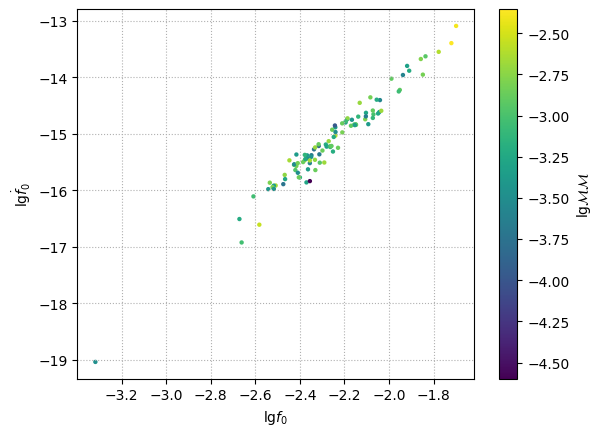

In [17]:
sc = plt.scatter(np.log10(GB_parameters["f0"][:num_test_GBs]), np.log10(GB_parameters["fdot0"][:num_test_GBs]), c=np.log10(min_MMs), cmap='viridis', edgecolor='none', s=10)

cbar = plt.colorbar(sc)
cbar.set_label(r'$\mathrm{lg}\mathcal{MM}$')
plt.xlabel(r'$\mathrm{lg}f_0$')
plt.ylabel(r'$\mathrm{lg}\dot{f}_0$')
plt.grid(linestyle=":")
